<a href="https://colab.research.google.com/github/tibayo1/DL-Lung-Sounds/blob/master/Lung_Sounds_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Needed. 

In [0]:
pip install pysoundfile

In [0]:
import os
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display
import pandas as pd
import soundfile as sf
import numpy as np

#to play audio
import IPython.display as ipd


Importing the Dataset from kaggle

Source: [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database)


In [0]:
import json

# read file
with open('/content/kaggle (1).json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
#get username and key
kaggle_key = str(obj['key'])
kaggle_username = str(obj['username'])


In [4]:
import os

# parse file
obj = json.loads(data)

os.environ['KAGGLE_USERNAME'] = kaggle_username # username from the json file
os.environ['KAGGLE_KEY'] = kaggle_key # key from the json file
!kaggle datasets download -d "vbookshelf/respiratory-sound-database" # api copied from kaggle



100% 3.68G/3.69G [02:00<00:00, 28.6MB/s]
100% 3.69G/3.69G [02:00<00:00, 32.8MB/s]


In [0]:
#unzip the folder downloaded from kaggle
!unzip 'respiratory-sound-database.zip'

List Directories available in the Datasets

In [6]:
os.listdir("/content/respiratory_sound_database/Respiratory_Sound_Database")

['filename_format.txt',
 'audio_and_txt_files',
 'patient_diagnosis.csv',
 'filename_differences.txt']

# Create a Spectogram

Spectrograms are a useful technique for visualising the spectrum of frequencies of a sound and how they vary during a very short period of time.

Display of Annotation: A quick look at datasets based on their respiratory cycles, presence or absence of crackles or wheezes.

In [7]:
path = \
'/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/154_2b4_Al_mc_AKGC417L.txt'

col_names = ['Beginning_of_respiratory_cycle', 'End_of_respiratory_cycle', 'Presence/absence_of_crackles', 'Presence/absence_of_wheezes']

# Respiratory cycle column values are in 'seconds'.
# Presence = 1
# Absence = 0

df_annot = pd.read_csv(path, sep="\t", header=None, names=col_names)

df_annot.head(10)

,Beginning_of_respiratory_cycle,End_of_respiratory_cycle,Presence/absence_of_crackles,Presence/absence_of_wheezes
0,1.330,3.804,0,0
1,3.804,6.396,0,0
2,6.396,8.938,1,0
3,8.938,11.580,1,0
4,11.580,14.072,1,0
5,14.072,17.049,1,0
6,17.049,19.490,1,0


In [0]:
# Define helper functions

# Load a .wav file. 
# These are 24 bit files. The PySoundFile library is able to read 24 bit files.
# https://pysoundfile.readthedocs.io/en/0.9.0/

def get_wav_info(wav_file_2):
    data, rate = sf.read(wav_file_2)
    return data, rate

# source: Andrew Ng Deep Learning Specialization, Course 5
def graph_spectrogram(wav):
    data, rate = get_wav_info(wav)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


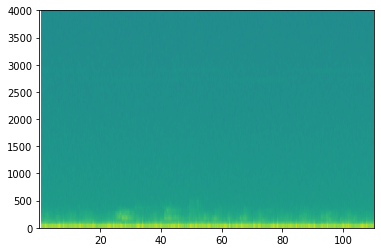

In [9]:
#Picking out one sound and viewing the spectrogram
path = \
'/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/154_2b4_Al_mc_AKGC417L.wav'
x = graph_spectrogram(path)

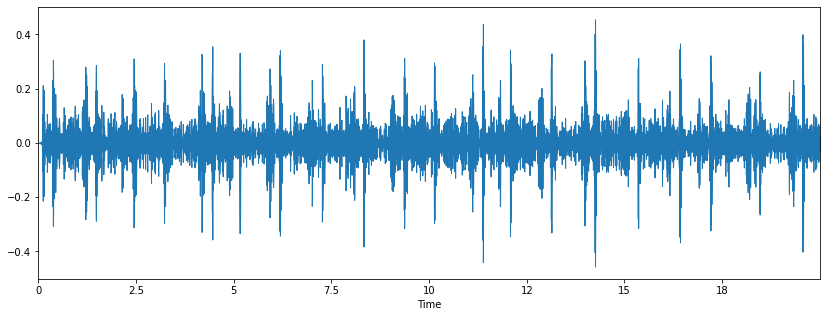

In [10]:
x, sr = librosa.load(path, sr=200)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

**Mel Spectogram (MFCC)**

For each audio file in the dataset, we will extract an MFCC (meaning we have an image representation for each audio sample0

In [0]:
audio_path = \
'/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/154_2b4_Al_mc_AKGC417L.wav'

# or uncomment the line below and point it at your favorite song:
#
# audio_path = '/path/to/your/favorite/song.mp3'

y, sr = librosa.load(audio_path)

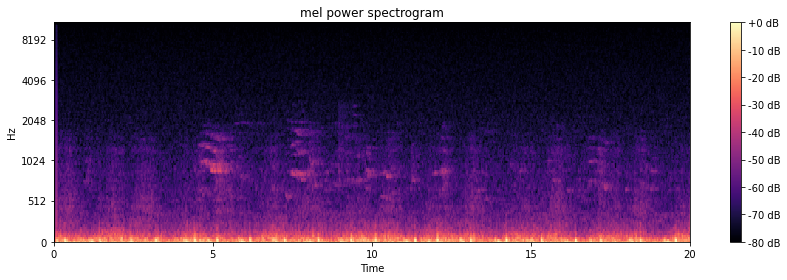

In [11]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()


# **[Harmonic-percussive source separation](https://nbviewer.jupyter.org/github/bmcfee/librosa/blob/master/examples/LibROSA%20demo.ipynb)**

In [0]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

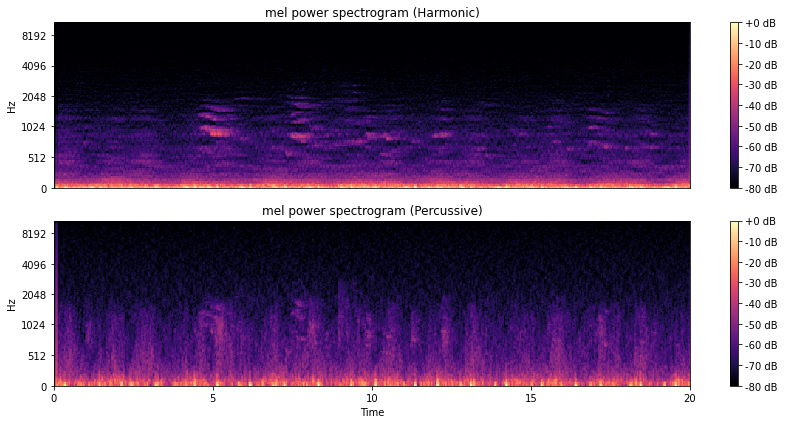

In [13]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()
